In [2]:
# --------------------------------------------------------------
# FINAL: FULL TRAINING + CHECKPOINTS + RESUME + F1 + TFLITE
# --------------------------------------------------------------

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, json, numpy as np, tensorflow as tf
from pathlib import Path
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import applications, layers, models, callbacks

# ---------- 0. COUNT IMAGES ----------
def count_images(folder):
    return len([f for f in Path(folder).iterdir()
                if f.suffix.lower() in {'.jpg', '.jpeg', '.png'}])

print("=== COUNTS ===")
print("NTU orig :", count_images("/content/drive/MyDrive/NTU-Roselab-Dataset/originals"))
print("NTU recp :", count_images("/content/drive/MyDrive/NTU-Roselab-Dataset/recaptures"))
print("Mob orig :", count_images("/content/drive/MyDrive/Nothing_2a/originals"))
print("Mob recp :", count_images("/content/drive/MyDrive/Nothing_2a/recaptures"))

# ---------- 1. SETTINGS ----------
MERGED_ROOT   = "/content/merged_dataset"
RESULTS_DIR   = "/content/drive/MyDrive/Merged_Model/results_final"
CHECKPOINT_DIR = f"{RESULTS_DIR}/checkpoints"
Path(RESULTS_DIR).mkdir(parents=True, exist_ok=True)
Path(CHECKPOINT_DIR).mkdir(parents=True, exist_ok=True)

# ---------- 2. REBUILD merged_dataset ----------
!rm -rf {MERGED_ROOT}
os.makedirs(f"{MERGED_ROOT}/originals", exist_ok=True)
os.makedirs(f"{MERGED_ROOT}/recaptures", exist_ok=True)

def link_flat(src, dst, prefix=None):
    if not Path(src).exists():
        print(f"   [MISSING] {src}")
        return 0
    cnt = 0
    for img in Path(src).iterdir():
        if img.suffix.lower() in {".jpg", ".jpeg", ".png"}:
            name = f"{prefix}_{img.name}" if prefix else img.name
            dst_path = Path(dst) / name
            if not dst_path.exists():
                os.symlink(img, dst_path)
                cnt += 1
    return cnt

print("\nLinking datasets...")
ntu_o = link_flat("/content/drive/MyDrive/NTU-Roselab-Dataset/originals", f"{MERGED_ROOT}/originals")
ntu_r = link_flat("/content/drive/MyDrive/NTU-Roselab-Dataset/recaptures", f"{MERGED_ROOT}/recaptures")
mob_o = link_flat("/content/drive/MyDrive/Nothing_2a/originals", f"{MERGED_ROOT}/originals", "nothing")
mob_r = link_flat("/content/drive/MyDrive/Nothing_2a/recaptures", f"{MERGED_ROOT}/recaptures", "nothing")

print(f"   NTU : {ntu_o} orig, {ntu_r} recp")
print(f"   Mob : {mob_o} orig, {mob_r} recp")

# ---------- 3. SPLIT 80/20 ----------
def get_paths(folder, prefix=None):
    return [p for p in Path(folder).iterdir()
            if p.suffix.lower() in {".jpg", ".jpeg", ".png"}
            and (prefix is None or p.name.startswith(f"{prefix}_"))]

all_ntu_o = get_paths(f"{MERGED_ROOT}/originals")
all_ntu_r = get_paths(f"{MERGED_ROOT}/recaptures")
all_mob_o = get_paths(f"{MERGED_ROOT}/originals", "nothing")
all_mob_r = get_paths(f"{MERGED_ROOT}/recaptures", "nothing")

np.random.seed(42)
np.random.shuffle(all_ntu_o); np.random.shuffle(all_ntu_r)
np.random.shuffle(all_mob_o); np.random.shuffle(all_mob_r)

train_ntu_o = all_ntu_o[:int(0.8*len(all_ntu_o))]
val_ntu_o   = all_ntu_o[int(0.8*len(all_ntu_o)):]
train_ntu_r = all_ntu_r[:int(0.8*len(all_ntu_r))]
val_ntu_r   = all_ntu_r[int(0.8*len(all_ntu_r)):]

train_mob_o = all_mob_o[:int(0.8*len(all_mob_o))]
val_mob_o   = all_mob_o[int(0.8*len(all_mob_o)):]
train_mob_r = all_mob_r[:int(0.8*len(all_mob_r))]
val_mob_r   = all_mob_r[int(0.8*len(all_mob_r)):]

print(f"\nTRAIN → NTU {len(train_ntu_o)+len(train_ntu_r)} | Mobile {len(train_mob_o)+len(train_mob_r)}")
print(f"VAL   → NTU {len(val_ntu_o)+len(val_ntu_r)} | Mobile {len(val_mob_o)+len(val_mob_r)}")

# ---------- 4. tf.data ----------
def decode(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = img[:, :, :3]
    img = tf.image.resize(img, (224, 224))
    return tf.keras.applications.efficientnet.preprocess_input(img)

def get_label(path):
    return tf.cast(tf.strings.split(path, os.sep)[-2] == "recaptures", tf.float32)

# TRAIN
train_paths = [str(p) for p in train_ntu_o + train_ntu_r + train_mob_o + train_mob_r]
train_ds = tf.data.Dataset.from_tensor_slices(train_paths)
train_ds = train_ds.map(lambda p: (p, tf.strings.split(p, os.sep)[-1]))

android_ds = train_ds.filter(lambda p, fn: tf.strings.regex_full_match(fn, "nothing_.*"))
ntu_ds     = train_ds.filter(lambda p, fn: ~tf.strings.regex_full_match(fn, "nothing_.*"))

android_ds = android_ds.map(lambda p, _: (decode(p), get_label(p))).repeat(8).shuffle(2000)
ntu_ds     = ntu_ds.map(lambda p, _: (decode(p), get_label(p)))

train_ds = android_ds.concatenate(ntu_ds).shuffle(4000).batch(16).prefetch(tf.data.AUTOTUNE)

# VAL
val_paths = [str(p) for p in val_ntu_o + val_ntu_r + val_mob_o + val_mob_r]
val_ds = tf.data.Dataset.from_tensor_slices(val_paths)
val_ds = val_ds.map(lambda p: (decode(p), get_label(p))).batch(32).prefetch(tf.data.AUTOTUNE)

# ---------- 5. MODEL ----------
inp = tf.keras.Input((224, 224, 3))
base = applications.EfficientNetB0(include_top=False, weights='imagenet')(inp)
x = layers.GlobalAveragePooling2D()(base)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
out = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(inp, out)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'])

# ---------- 6. CALLBACKS ----------
checkpoint_path = f"{CHECKPOINT_DIR}/cp-best.weights.h5"

cp_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_f1_score',
    mode='max',
    save_best_only=True,
    verbose=1
)

class F1Callback(tf.keras.callbacks.Callback):
    def __init__(self, val_ds):
        super().__init__()
        self.val_ds = val_ds
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        y_true, y_pred = [], []
        for xb, yb in self.val_ds:
            pred = (self.model.predict(xb, verbose=0) > 0.5).astype(int)
            y_true.extend(yb.numpy())
            y_pred.extend(pred.flatten())
        # Use class name, not numeric label
        f1 = classification_report(y_true, y_pred,
                                   target_names=['Original','Recaptured'],
                                   output_dict=True)['Recaptured']['f1-score']
        logs['val_f1_score'] = f1
        print(f" — val_f1_score: {f1:.4f}")

f1_cb = F1Callback(val_ds)

early_stop = callbacks.EarlyStopping(
    monitor='val_f1_score',
    mode='max',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# RESUME
if os.path.exists(checkpoint_path):
    print("Resuming from checkpoint...")
    model.load_weights(checkpoint_path)

# ---------- 7. TRAIN ----------
print("\nStarting training...")
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    steps_per_epoch=250,
    callbacks=[cp_callback, f1_cb, early_stop],
    verbose=1
)

# ---------- 8. FINAL EVAL ----------
y_true, y_pred = [], []
for xb, yb in val_ds:
    pred = model.predict(xb, verbose=0)
    y_true.extend(yb.numpy())
    y_pred.extend((pred > 0.5).astype(int).flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred,
                               target_names=['Original','Recaptured'],
                               output_dict=True)
acc = cm.diagonal().sum() / cm.sum()
f1_rec = report['Recaptured']['f1-score']

# CONFUSION MATRIX
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Original','Recaptured'],
            yticklabels=['Original','Recaptured'])
plt.title(f'CM – Acc: {acc:.2%} | F1-Rec: {f1_rec:.2f}')
plt.ylabel('True'); plt.xlabel('Predicted')
plt.savefig(f"{RESULTS_DIR}/confusion_matrix.png", dpi=200, bbox_inches='tight')
plt.close()

# CLASSIFICATION REPORT (2 dp)
df_rep = pd.DataFrame(report).transpose().round(2)
df_rep.to_csv(f"{RESULTS_DIR}/classification_report.csv")

# METRICS JSON (4 dp)
metrics = {
    "val_accuracy": round(float(acc), 4),
    "f1_recaptured": round(f1_rec, 4),
    "original_correct": int(cm[0,0]),
    "recaptured_correct": int(cm[1,1]),
    "total_samples": int(cm.sum())
}
with open(f"{RESULTS_DIR}/metrics_summary.json", 'w') as f:
    json.dump(metrics, f, indent=2)

print("\n" + "="*60)
print("FINAL RESULTS")
print(f"Val Accuracy : {acc:.2%}")
print(f"F1 (Recaptured): {f1_rec:.2f}")
print(f"Original     : {cm[0,0]}/{cm[0].sum()}")
print(f"Recaptured   : {cm[1,1]}/{cm[1].sum()}")
print("="*60)

# ---------- 9. SAVE + TFLITE ----------
model.save(f"{RESULTS_DIR}/final_model.keras")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite = converter.convert()
with open(f"{RESULTS_DIR}/recapture_detector.tflite", 'wb') as f:
    f.write(tflite)

print(f"TFLite saved: {RESULTS_DIR}/recapture_detector.tflite")

Mounted at /content/drive
=== COUNTS ===
NTU orig : 1202
NTU recp : 1199
Mob orig : 106
Mob recp : 103

Linking datasets...
   NTU : 1202 orig, 1199 recp
   Mob : 106 orig, 103 recp

TRAIN → NTU 2087 | Mobile 166
VAL   → NTU 523 | Mobile 43
Resuming from checkpoint...

Starting training...
Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 432 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - Precision: 0.8944 - Recall: 0.9076 - accuracy: 0.9050 - loss: 0.2353

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_f1_score available.
  if self._should_save_model(epoch, batch, logs, filepath):


 — val_f1_score: 0.8056
250/250 ━━━━━━━━━━━━━━━━━━━━ 1037s 741ms/step - Precision: 0.8944 - Recall: 0.9076 - accuracy: 0.9050 - loss: 0.2353 - val_Precision: 0.9144 - val_Recall: 0.7199 - val_accuracy: 0.8269 - val_loss: 0.5961 - val_f1_score: 0.8056
Epoch 2/30
 37/250 ━━━━━━━━━━━━━━━━━━━━ 4:57 1s/step - Precision: 0.9057 - Recall: 0.9270 - accuracy: 0.9182 - loss: 0.2088 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_f1_score available.
  if self._should_save_model(epoch, batch, logs, filepath):


 — val_f1_score: 0.8189
250/250 ━━━━━━━━━━━━━━━━━━━━ 179s 719ms/step - Precision: 0.9020 - Recall: 0.9266 - accuracy: 0.9158 - loss: 0.2099 - val_Precision: 0.9204 - val_Recall: 0.7376 - val_accuracy: 0.8375 - val_loss: 0.5723 - val_f1_score: 0.8189
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - Precision: 0.9390 - Recall: 0.9371 - accuracy: 0.9389 - loss: 0.1614

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_f1_score available.
  if self._should_save_model(epoch, batch, logs, filepath):


 — val_f1_score: 0.7837
250/250 ━━━━━━━━━━━━━━━━━━━━ 982s 722ms/step - Precision: 0.9390 - Recall: 0.9372 - accuracy: 0.9389 - loss: 0.1614 - val_Precision: 0.6488 - val_Recall: 0.9894 - val_accuracy: 0.7279 - val_loss: 0.6167 - val_f1_score: 0.7837
Epoch 4/30
 37/250 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step - Precision: 0.9328 - Recall: 0.9348 - accuracy: 0.9346 - loss: 0.1560

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_f1_score available.
  if self._should_save_model(epoch, batch, logs, filepath):


 — val_f1_score: 0.8681
250/250 ━━━━━━━━━━━━━━━━━━━━ 99s 396ms/step - Precision: 0.9243 - Recall: 0.9408 - accuracy: 0.9327 - loss: 0.1659 - val_Precision: 0.8202 - val_Recall: 0.9220 - val_accuracy: 0.8604 - val_loss: 0.3220 - val_f1_score: 0.8681
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - Precision: 0.9546 - Recall: 0.9576 - accuracy: 0.9576 - loss: 0.1089

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_f1_score available.
  if self._should_save_model(epoch, batch, logs, filepath):


 — val_f1_score: 0.8677
250/250 ━━━━━━━━━━━━━━━━━━━━ 970s 715ms/step - Precision: 0.9546 - Recall: 0.9576 - accuracy: 0.9576 - loss: 0.1089 - val_Precision: 0.7959 - val_Recall: 0.9539 - val_accuracy: 0.8551 - val_loss: 0.3415 - val_f1_score: 0.8677
Epoch 6/30
 37/250 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step - Precision: 0.9787 - Recall: 0.9665 - accuracy: 0.9701 - loss: 0.0883

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_f1_score available.
  if self._should_save_model(epoch, batch, logs, filepath):


 — val_f1_score: 0.8839
250/250 ━━━━━━━━━━━━━━━━━━━━ 101s 407ms/step - Precision: 0.9687 - Recall: 0.9509 - accuracy: 0.9581 - loss: 0.1089 - val_Precision: 0.8107 - val_Recall: 0.9716 - val_accuracy: 0.8728 - val_loss: 0.3612 - val_f1_score: 0.8839
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - Precision: 0.9703 - Recall: 0.9764 - accuracy: 0.9732 - loss: 0.0847

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_f1_score available.
  if self._should_save_model(epoch, batch, logs, filepath):


 — val_f1_score: 0.8421
250/250 ━━━━━━━━━━━━━━━━━━━━ 966s 702ms/step - Precision: 0.9703 - Recall: 0.9764 - accuracy: 0.9732 - loss: 0.0848 - val_Precision: 0.9811 - val_Recall: 0.7376 - val_accuracy: 0.8622 - val_loss: 0.4538 - val_f1_score: 0.8421
Epoch 8/30
 37/250 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - Precision: 0.9814 - Recall: 0.9836 - accuracy: 0.9828 - loss: 0.0479

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_f1_score available.
  if self._should_save_model(epoch, batch, logs, filepath):


 — val_f1_score: 0.9027
250/250 ━━━━━━━━━━━━━━━━━━━━ 134s 539ms/step - Precision: 0.9799 - Recall: 0.9774 - accuracy: 0.9787 - loss: 0.0527 - val_Precision: 0.9011 - val_Recall: 0.9043 - val_accuracy: 0.9028 - val_loss: 0.3158 - val_f1_score: 0.9027
Epoch 9/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - Precision: 0.9736 - Recall: 0.9674 - accuracy: 0.9720 - loss: 0.0822

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_f1_score available.
  if self._should_save_model(epoch, batch, logs, filepath):


 — val_f1_score: 0.9228
250/250 ━━━━━━━━━━━━━━━━━━━━ 963s 716ms/step - Precision: 0.9736 - Recall: 0.9674 - accuracy: 0.9720 - loss: 0.0822 - val_Precision: 0.9132 - val_Recall: 0.9326 - val_accuracy: 0.9223 - val_loss: 0.2353 - val_f1_score: 0.9228
Epoch 10/30
 37/250 ━━━━━━━━━━━━━━━━━━━━ 16s 78ms/step - Precision: 0.9864 - Recall: 0.9713 - accuracy: 0.9793 - loss: 0.0592

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_f1_score available.
  if self._should_save_model(epoch, batch, logs, filepath):


 — val_f1_score: 0.9012
250/250 ━━━━━━━━━━━━━━━━━━━━ 104s 417ms/step - Precision: 0.9866 - Recall: 0.9679 - accuracy: 0.9768 - loss: 0.0692 - val_Precision: 0.8814 - val_Recall: 0.9220 - val_accuracy: 0.8993 - val_loss: 0.2622 - val_f1_score: 0.9012
Epoch 11/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - Precision: 0.9760 - Recall: 0.9799 - accuracy: 0.9788 - loss: 0.0567

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_f1_score available.
  if self._should_save_model(epoch, batch, logs, filepath):


 — val_f1_score: 0.9103
250/250 ━━━━━━━━━━━━━━━━━━━━ 995s 837ms/step - Precision: 0.9760 - Recall: 0.9799 - accuracy: 0.9788 - loss: 0.0567 - val_Precision: 0.8859 - val_Recall: 0.9362 - val_accuracy: 0.9081 - val_loss: 0.3684 - val_f1_score: 0.9103
Epoch 12/30
 37/250 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - Precision: 0.9557 - Recall: 0.9854 - accuracy: 0.9685 - loss: 0.0680

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_f1_score available.
  if self._should_save_model(epoch, batch, logs, filepath):


 — val_f1_score: 0.8851
250/250 ━━━━━━━━━━━━━━━━━━━━ 101s 406ms/step - Precision: 0.9637 - Recall: 0.9814 - accuracy: 0.9708 - loss: 0.0712 - val_Precision: 0.8452 - val_Recall: 0.9291 - val_accuracy: 0.8799 - val_loss: 0.3373 - val_f1_score: 0.8851
Epoch 13/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - Precision: 0.9751 - Recall: 0.9805 - accuracy: 0.9786 - loss: 0.0633

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_f1_score available.
  if self._should_save_model(epoch, batch, logs, filepath):


 — val_f1_score: 0.9191
250/250 ━━━━━━━━━━━━━━━━━━━━ 973s 710ms/step - Precision: 0.9751 - Recall: 0.9805 - accuracy: 0.9786 - loss: 0.0633 - val_Precision: 0.8930 - val_Recall: 0.9468 - val_accuracy: 0.9170 - val_loss: 0.3251 - val_f1_score: 0.9191
Epoch 14/30
 37/250 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - Precision: 0.9785 - Recall: 0.9798 - accuracy: 0.9784 - loss: 0.0927

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_f1_score available.
  if self._should_save_model(epoch, batch, logs, filepath):


 — val_f1_score: 0.8936
250/250 ━━━━━━━━━━━━━━━━━━━━ 137s 550ms/step - Precision: 0.9745 - Recall: 0.9747 - accuracy: 0.9737 - loss: 0.1131 - val_Precision: 0.8936 - val_Recall: 0.8936 - val_accuracy: 0.8940 - val_loss: 0.3115 - val_f1_score: 0.8936
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 9.

FINAL RESULTS
Val Accuracy : 92.23%
F1 (Recaptured): 0.92
Original     : 259/284
Recaptured   : 263/282
Saved artifact at '/tmp/tmpxp8p66vy'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_480')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140113582060752: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  140113582059600: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  140114061278096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140114061277520: TensorSpec(shape=(), dtype

## Testing

Model loaded

IMG_20251110_123014661.jpg
→ Recaptured (92.21%)


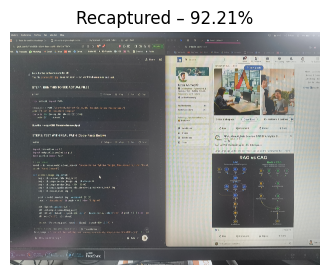

In [11]:
# --------------------------------------------------------------
# QUICK TEST BY PATH – FIND A REAL FILE FIRST
# --------------------------------------------------------------

import tensorflow as tf
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# ---- SETTINGS ----
RESULTS_DIR = "/content/drive/MyDrive/Merged_Model/results_final"
MODEL_PATH  = f"{RESULTS_DIR}/final_model.keras"
IMG_SIZE    = (224, 224)

# ---- LOAD MODEL ----
model = tf.keras.models.load_model(MODEL_PATH)
print("Model loaded")

# ---- PREPROCESS ----
def preprocess(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return tf.expand_dims(img, 0)          # (1,224,224,3)

# ---- PREDICT + SHOW ----
def predict_path(path):
    x = preprocess(path)
    prob = model.predict(x, verbose=0)[0][0]
    label = "Recaptured" if prob > 0.5 else "Original"
    print(f"\n{Path(path).name}")
    print(f"→ {label} ({prob*100:5.2f}%)")
    plt.figure(figsize=(4,4))
    plt.imshow(plt.imread(path))
    plt.title(f"{label} – {prob*100:.2f}%")
    plt.axis('off'); plt.show()



# --------------------------------------------------------------
# 2. TEST WITH A REAL PATH (paste one from above)
# --------------------------------------------------------------
test_image = "/content/drive/MyDrive/IMG_20251110_123014661.jpg"
predict_path(test_image)

Model loaded
Converted: IMG_3154.HEIC → IMG_3154.jpg

IMG_3154.jpg
→ Recaptured (99.99%)


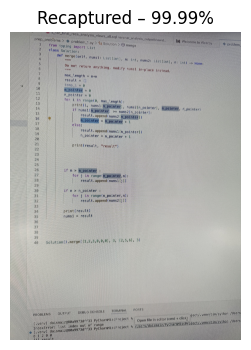

In [17]:
!pip install pyheif pillow -q

from PIL import Image
import pyheif
from pathlib import Path

import tensorflow as tf
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# ---- SETTINGS ----
RESULTS_DIR = "/content/drive/MyDrive/Merged_Model/results_final"
MODEL_PATH  = f"{RESULTS_DIR}/final_model.keras"
IMG_SIZE    = (224, 224)

# ---- LOAD MODEL ----
model = tf.keras.models.load_model(MODEL_PATH)
print("Model loaded")

# ---- PREPROCESS ----
def preprocess(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return tf.expand_dims(img, 0)

# ---- PREDICT + SHOW ----
def predict_path(path):
    x = preprocess(path)
    prob = model.predict(x, verbose=0)[0][0]
    label = "Recaptured" if prob > 0.5 else "Original"
    print(f"\n{Path(path).name}")
    print(f"→ {label} ({prob*100:5.2f}%)")
    plt.figure(figsize=(4,4))
    plt.imshow(plt.imread(path))
    plt.title(f"{label} – {prob*100:.2f}%")
    plt.axis('off'); plt.show()


def heic_to_jpg(heic_path, jpg_path=None):
    heif_file = pyheif.read(heic_path)
    image = Image.frombytes(
        heif_file.mode,
        heif_file.size,
        heif_file.data,
        "raw",
        heif_file.mode,
        heif_file.stride,
    )
    jpg_path = jpg_path or str(Path(heic_path).with_suffix(".jpg"))
    image.save(jpg_path, "JPEG", quality=95)
    print(f"Converted: {Path(heic_path).name} → {Path(jpg_path).name}")
    return jpg_path

# USE IT
heic_file = "/content/drive/MyDrive/IMG_3154.HEIC"
jpg_file = heic_to_jpg(heic_file)

# Now test with model
predict_path(jpg_file)